# Pipeline
* Take videos
* Sample at 1 fps
* Extract KAZE descriptors

* For input take a subsample of a video
* Sample at 1 fps
* Extract KAZE descriptors
* Make matrix of KAZE descriptors
* Find all candidates for sequence start
    * Extract matrices of KAZE descriptors
    * Find matrix with min cosine distance

In [38]:
import cv2
import numpy as np
import pandas as pd
import scipy
from scipy.misc import imread
import cPickle as pickle
import random
import os
import matplotlib.pyplot as plt
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import VideoFileClip
import shutil
from PIL import Image
from tqdm import tqdm
%matplotlib inline

In [123]:

def plot_img(img):
	plt.imshow(img)

def plot_img_file(path):
    img = imread(path, mode="RGB")
    show_img(img)

def extract_image_features(image, vector_size=32):
    # Using KAZE, cause SIFT, ORB and other was moved to additional module
    # which is adding addtional pain during install
    alg = cv2.KAZE_create()
    # Dinding image keypoints
    kps = alg.detect(image)
    # Getting first 32 of them. 
    # Number of keypoints is varies depend on image size and color pallet
    # Sorting them based on keypoint response value(bigger is better)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    # computing descriptors vector
    kps, dsc = alg.compute(image, kps)
    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (vector_size * 64)
    # Flatten all of them in one big vector - our feature vector
    dsc = dsc.flatten() if dsc is not None else np.zeros(needed_size)
    if dsc.size < needed_size:
        # if we have less the 32 descriptors then just adding zeros at the
        # end of our feature vector
        dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    #except cv2.error as e:
    #    print 'Error: ', e
    #    return None
    return dsc

def preprocess_image(image):
    img = Image.fromarray(image)
    img = img.resize(IMG_SIZE)
    return np.array(img)

def get_video_rows(path, frames_mod, write_frames_dir):
    frames_path = None
    if write_frames_dir:
        frames_path = os.path.join(write_frames_dir, os.path.basename(path)+'_frames')
        if os.path.exists(frames_path):
            shutil.rmtree(frames_path)
        os.makedirs(frames_path)
            
    rows = []
    
    vid = cv2.VideoCapture(path)
    video_name = os.path.basename(path)
    width = int(vid.get(3))
    height = int(vid.get(4))
    
    index = 0
    while(True):
        ret, frame = vid.read()
        if not ret: 
            break

        if index % frames_mod == 0:
            frame = preprocess_image(frame.astype('uint8'))
            
            features = extract_image_features(frame)
            row = {
                'video_path': path,
                'frame_index': index,
            }
            for i in range(len(features)):
                row['x_{}'.format(i)] = features[i]
            rows.append(row)
            if frames_path:
                fpath = os.path.join(frames_path, '{}.jpg'.format(str(index)))
                cv2.imwrite(fpath, frame)            
            
        index += 1
    vid.release()
    return rows
    
def get_dataframe(inp_files, frames_mod=28, write_frames_dir=None):
    '''
        inp_files - either a list of filepaths or a directory path
    '''
    if isinstance(inp_files, list):
        fpaths = inp_files
    else:
        fpaths = [os.path.join(inp_files, fname) for fname in os.listdir(inp_files)]
    rows = []
    for fpath in tqdm(fpaths):
        print 'Processing', fpath
        video_rows = get_video_rows(fpath, frames_mod, write_frames_dir)
        rows += video_rows
    df = pd.DataFrame.from_dict(rows).sort_values(by=['video_path', 'frame_index']).reset_index(drop=True)
    return df

def draw_video_frame(path, index):
    vid = cv2.VideoCapture(path)    
    vid.set(cv2.CAP_PROP_POS_FRAMES, index)
    i = 0
    while(True):        
        ret, frame = vid.read()
        if not ret: 
            break
        if i == index:
            frame = preprocess_image(frame.astype('uint8'))
            plot_img(frame)
            plt.show()
            break
        i+=1
    vid.release()


In [124]:
FRAMES_MOD = 100
IMG_SIZE=(600,600)
video_folder = '../data'
frame_dir_path = './frames'
tmp_dir_path = './tmp'

if os.path.exists(frame_dir_path):
    shutil.rmtree(frame_dir_path)
os.makedirs(frame_dir_path)
    
if os.path.exists(tmp_dir_path):
    shutil.rmtree(tmp_dir_path)
os.makedirs(tmp_dir_path)

In [126]:
%%time
df = get_dataframe(video_folder, FRAMES_MOD)#, frame_dir_path)






  0%|          | 0/5 [00:00<?, ?it/s]

Processing ../data/byvshye_s01_ep01_eg01_____2018-05-30.mp4







 20%|██        | 1/5 [00:01<00:05,  1.30s/it]

Processing ../data/v_854x480__c_hevc.mp4







 40%|████      | 2/5 [00:03<00:05,  1.68s/it]

Processing ../data/The.Young.Pope.S01E02.HDTVRip.Jaskier.avi


KeyboardInterrupt: 

In [42]:
df.head()

,frame_index,video_path,x_0,x_1,x_10,x_100,x_1000,x_1001,x_1002,x_1003,...,x_990,x_991,x_992,x_993,x_994,x_995,x_996,x_997,x_998,x_999
0,0,../data/The.Young.Pope.S01E01.HDTVRip.Jaskier.avi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100,../data/The.Young.Pope.S01E01.HDTVRip.Jaskier.avi,117.0,176.0,166.0,50.0,94.0,130.0,98.0,74.0,...,86.0,98.0,51.0,164.0,215.0,95.0,126.0,11.0,164.0,232.0
2,200,../data/The.Young.Pope.S01E01.HDTVRip.Jaskier.avi,244.0,85.0,163.0,4.0,62.0,180.0,194.0,163.0,...,26.0,10.0,18.0,32.0,198.0,61.0,14.0,11.0,161.0,72.0
3,300,../data/The.Young.Pope.S01E01.HDTVRip.Jaskier.avi,29.0,103.0,250.0,40.0,112.0,234.0,115.0,196.0,...,198.0,34.0,197.0,38.0,195.0,5.0,96.0,14.0,238.0,48.0
4,400,../data/The.Young.Pope.S01E01.HDTVRip.Jaskier.avi,244.0,121.0,167.0,152.0,49.0,30.0,126.0,248.0,...,135.0,232.0,216.0,135.0,180.0,119.0,163.0,28.0,125.0,183.0


In [43]:
frame_indices = df.frame_index
Y = df.video_path
X = df.drop(['frame_index', 'video_path'], axis=1)

In [44]:
#X.head(), Y.head()

In [108]:
test_df = None
fname = os.listdir(video_folder)[2]

actual_video_path = os.path.join(video_folder, fname)
test_fpath = os.path.join(video_folder, fname)
subclip_fname = os.path.join(tmp_dir_path, 'subclip_'+fname)
clip = VideoFileClip(test_fpath)
duration = clip.duration
subclip_duration = min(max(5, int(duration*0.1)), FRAMES_MOD/2)
subclip_start_time = np.random.randint(0, duration-subclip_duration)
print 'Cutting %d - %d' % (subclip_start_time, subclip_start_time+subclip_duration)
ffmpeg_extract_subclip(test_fpath, subclip_start_time, subclip_start_time+subclip_duration, targetname=subclip_fname)
subclip_df = get_dataframe([subclip_fname], FRAMES_MOD, tmp_dir_path)
subclip_df['subclip_path'] = subclip_df.video_path
subclip_df['video_path'] = actual_video_path
#print(subclip_fname, fname, actual_video_path)
#print(subclip_df.head())
if test_df is None:
    test_df = subclip_df
else:
    test_df = pd.concat([test_df, subclip_df])


                                   

                                      


                             
  0%|          | 0/13 [19:03<?, ?it/s]

  0%|          | 0/13 [19:47<?, ?it/s]


  0%|          | 0/13 [16:35<?, ?it/s]
                                   

                                      


                             
  0%|          | 0/13 [19:04<?, ?it/s]

  0%|          | 0/13 [19:47<?, ?it/s]


  0%|          | 0/13 [16:36<?, ?it/s]



  0%|          | 0/1 [00:00<?, ?it/s]

Cutting 46 - 56
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Processing ./tmp/subclip_The.Young.Pope.S01E02.HDTVRip.Jaskier.avi






100%|██████████| 1/1 [00:00<00:00,  5.16it/s]





In [109]:
test_df.head()

,frame_index,video_path,x_0,x_1,x_10,x_100,x_1000,x_1001,x_1002,x_1003,...,x_991,x_992,x_993,x_994,x_995,x_996,x_997,x_998,x_999,subclip_path
0,0,../data/The.Young.Pope.S01E02.HDTVRip.Jaskier.avi,236.0,120.0,118.0,213.0,100.0,168.0,122.0,76.0,...,40.0,225.0,75.0,91.0,69.0,52.0,14.0,102.0,180.0,./tmp/subclip_The.Young.Pope.S01E02.HDTVRip.Ja...
1,100,../data/The.Young.Pope.S01E02.HDTVRip.Jaskier.avi,208.0,190.0,130.0,171.0,121.0,234.0,182.0,92.0,...,179.0,233.0,116.0,191.0,101.0,37.0,94.0,119.0,49.0,./tmp/subclip_The.Young.Pope.S01E02.HDTVRip.Ja...


Query frame from subclip


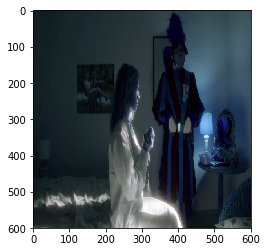

In [110]:
#print('Subclip from video', test_df.loc[0].video_path)
print('Query frame from subclip')
draw_video_frame(test_df.loc[0].subclip_path, test_df.loc[0].frame_index)

In [111]:
test_x = test_df.drop(['video_path', 'frame_index', 'subclip_path'], axis=1)
test_y = test_df.video_path

In [112]:
def get_closest_vector(vector, vectors):
    distances = scipy.spatial.distance.cdist(vectors, [vector], metric='cosine')   
    dist_flat = distances.flatten()
    if np.isnan(dist_flat).all():
        raise(Exception("Nan distances"))
    sorted_order = np.argsort(dist_flat)
    dist_flat_sorted = dist_flat[sorted_order]
    #print(sorted_order)
    #print(vectors.ix[sorted_order].head())
    return sorted_order[0], dist_flat_sorted[0]

In [113]:
target_vector = test_x.loc[0]
target_vector.values

array([236., 120., 118., ...,  14., 102., 180.])

In [114]:
closest_index, dist = get_closest_vector(test_x.loc[0], X)
fname_, frame_index_ = Y.loc[closest_index], frame_indices.loc[closest_index]
print(fname_, frame_index_, dist)

('../data/The.Young.Pope.S01E02.HDTVRip.Jaskier.avi', 1000, 0.09264500300721545)


Predicted frame from source video


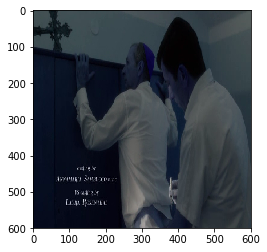

In [115]:
print('Predicted frame from source video')
draw_video_frame(fname_, frame_index_)

In [116]:
def sequential_predict(query_vectors, vectors):
    start_vector_index, dist = get_closest_vector(query_vectors.loc[0], vectors)
    query_len = len(query_vectors)
    j=1
    dists = [dist]
    for i in range(start_vector_index+1, start_vector_index+query_len):
        dists.append(scipy.spatial.distance.cdist([vectors.loc[i]], [query_vectors.loc[j]], metric='cosine')[0][0])
        j+=1
    
    return dists
sequential_predict(test_x, X)

[0.09264500300721545, 0.20500681693487333]

In [119]:
def majority_vote_predict(query_vectors, vectors, labels):
    votes = []
    dists = []
    for vector in query_vectors:
        pred_index, dist = get_closest_vector(vector, vectors)
        votes.append(labels[closest_index])
        dists.append(dist)
    print(votes)
    print(dists)
    moc= max([(votes.count(chr),chr) for chr in set(votes)])
    return moc
print('predicted', majority_vote_predict(test_x.values, X.values, Y))
print('real', test_y.loc[0])

['../data/The.Young.Pope.S01E02.HDTVRip.Jaskier.avi', '../data/The.Young.Pope.S01E02.HDTVRip.Jaskier.avi']
[0.09264500300721545, 0.13420559199378712]
('predicted', (2, '../data/The.Young.Pope.S01E02.HDTVRip.Jaskier.avi'))
('real', '../data/The.Young.Pope.S01E02.HDTVRip.Jaskier.avi')
